# ProDOT system clustering

Original paper: [Ioan2021](https://pubs.acs.org/doi/abs/10.1021/acs.macromol.0c02132)

In [1]:
import numpy as np
import time
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from ase.io import read
from tqdm import tqdm

In [2]:
sys.path.append('../../')

In [3]:
from src import myTools, plotTools

# HDBSCAN

Python library [hdbscan](https://hdbscan.readthedocs.io/en/latest/index.html)

In [4]:
import hdbscan

In [5]:
def make_colors(clust, mode='tab10'):
    if np.min(clust) == -1:
        N = np.unique(clust).shape[0] - 1
        colors = [(0,0,0)] + sns.color_palette(mode, N)
    else:
        N = np.unique(clust).shape[0]
        colors = sns.color_palette(mode, N)
    return colors

## PCA DATA

In [6]:
sysdir_path = './dimred_data/'
sysname = 'lpca9_n_Z1_Z3_Nframe5000.npy'

In [7]:
X = np.load(sysdir_path+sysname)
X.shape

(5000, 9)

In [8]:
og_labels = np.loadtxt('../0.data/ProDOT-2Hex-00PC-cryst.labels').astype(int)
og_labels

array([1, 1, 1, ..., 3, 3, 3])

### HDBSCAN clustering

#### Single evaluation

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5).fit(X)

In [10]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [12]:
colors = make_colors(clusterer.labels_, mode='viridis')
# colors

Text(0.5, 1.0, 'Ioan routine')

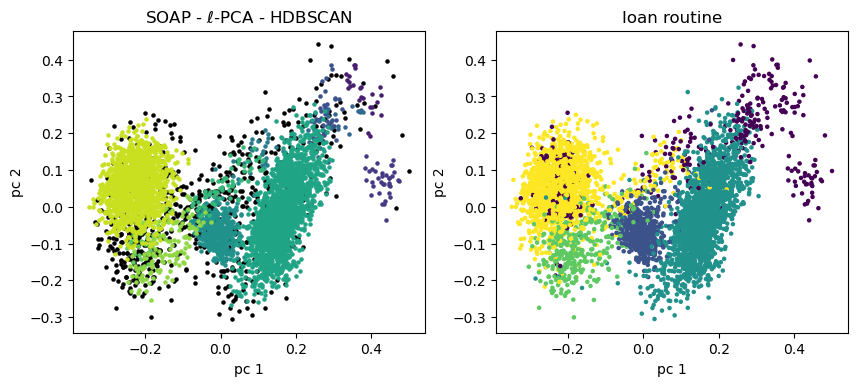

In [13]:
fig, ax = plotTools.get_axes(2,2,res=100)

for i,c in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == c
    ax[0].scatter(X[mask,0], X[mask,1], color=colors[i], s=5)
    ax[0].set_ylabel('pc 2')
    ax[0].set_xlabel('pc 1')
    ax[0].set_title('SOAP - $\ell$-PCA - HDBSCAN')
    
ax[1].scatter(X[:,0], X[:,1], c=og_labels, s=5)
ax[1].set_ylabel('pc 2')
ax[1].set_xlabel('pc 1')
ax[1].set_title('Ioan routine')
# fig.savefig('hdbscan_vs_ioan_5000pt.png')

#### Parameters search - Min Cluster Size

In [14]:
mcs = [2,5,10,20]

In [15]:
mcs_labels_dict = dict()

In [16]:
for n in tqdm(mcs):
    clust_tmp = hdbscan.HDBSCAN(min_cluster_size=n).fit(X)
    mcs_labels_dict['min_clust_size'+str(n)] = clust_tmp.labels_

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.86it/s]


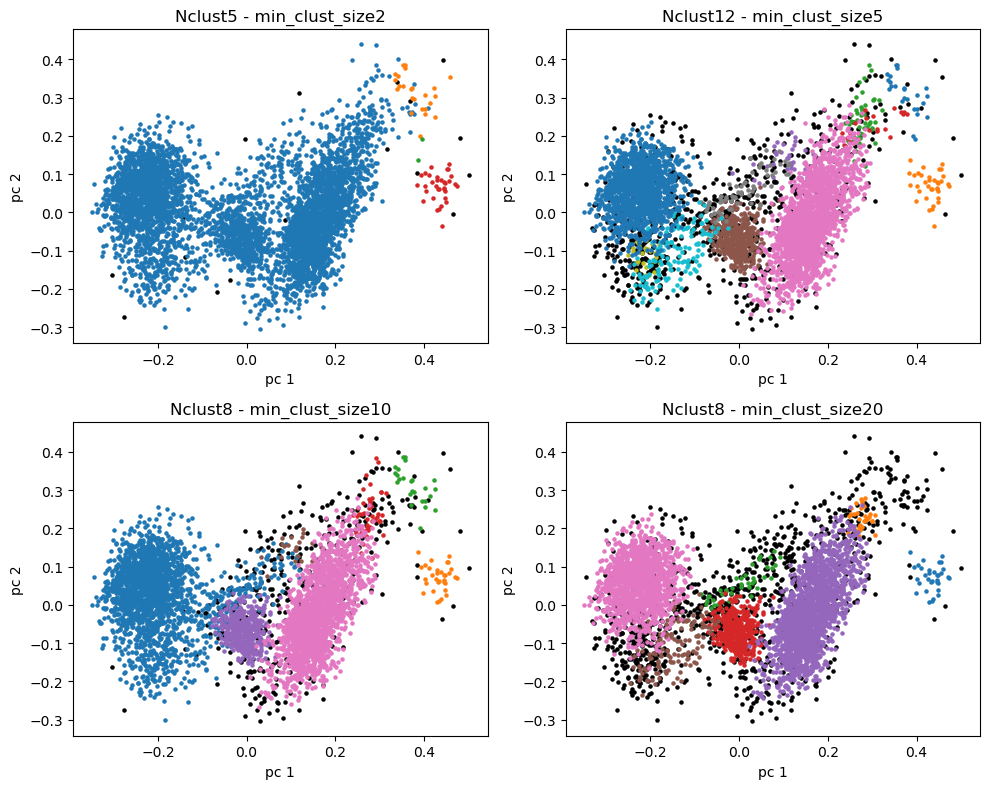

In [17]:
fig, ax = plotTools.get_axes(len(mcs),2,res=100)

for i,(n,c) in enumerate(mcs_labels_dict.items()):
    colors = make_colors(c)
    for x,j in enumerate(np.unique(c)):
        mask = c == j
        ax[i].scatter(X[mask,0], X[mask,1], color=colors[x], s=5)
        ax[i].set_ylabel('pc 2')
        ax[i].set_xlabel('pc 1')
        ax[i].set_title(f'Nclust{len(np.unique(c))} - '+n)
        
fig.tight_layout()
# fig.savefig('hdbscan_vs_ioan_5000pt_prmtr_search_0.png')

#### Final value

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=17).fit(X)
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [19]:
colors = make_colors(clusterer.labels_, mode='viridis')

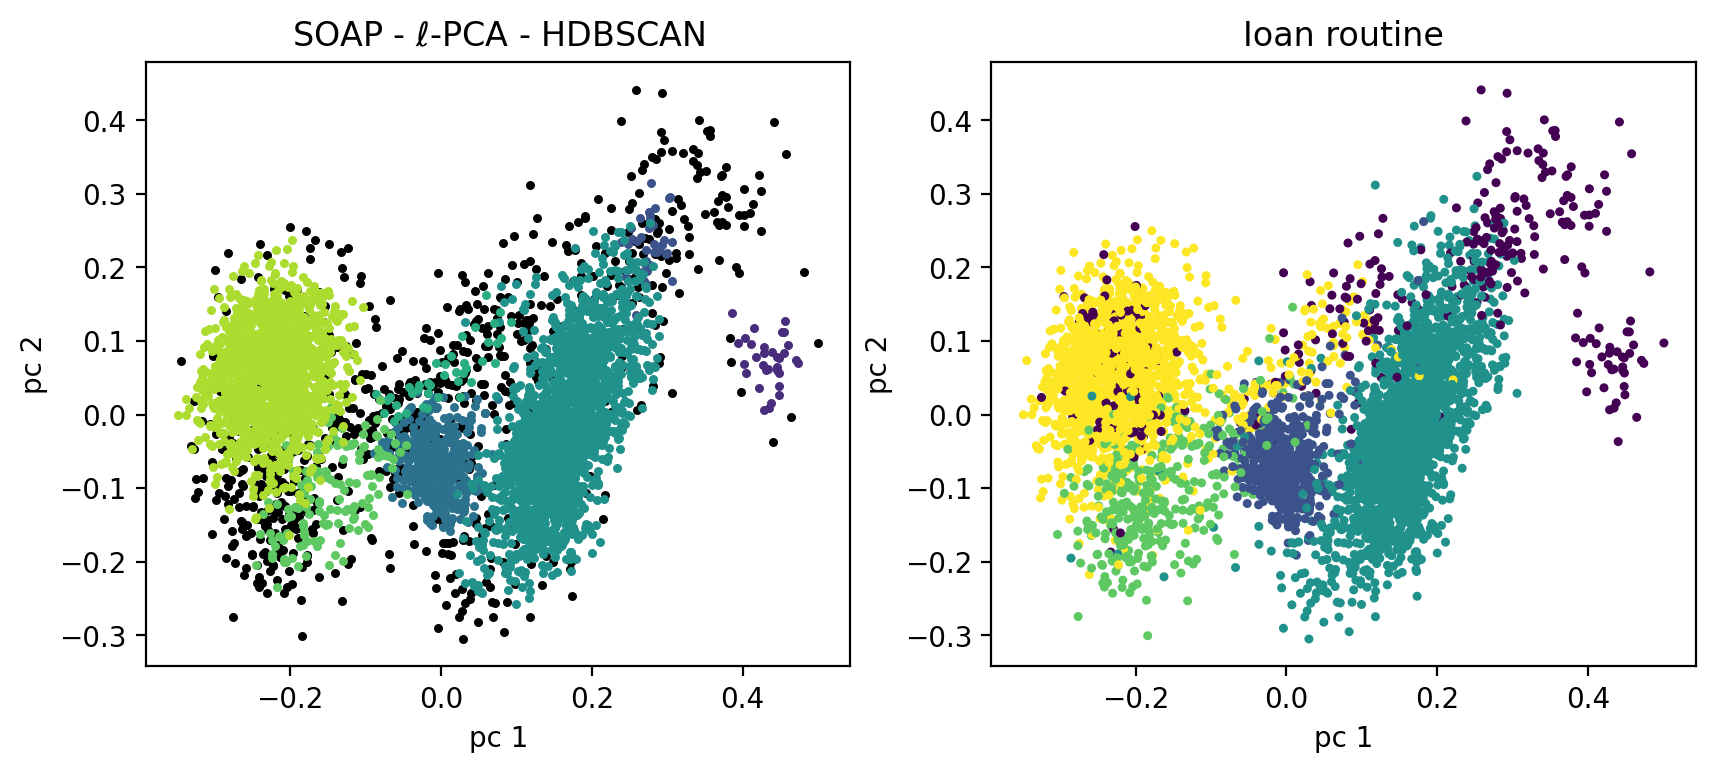

In [20]:
fig, ax = plotTools.get_axes(2,2,res=200)

for i,c in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == c
    ax[0].scatter(X[mask,0], X[mask,1], 
                  color=colors[i], s=5)
    ax[0].set_ylabel('pc 2')
    ax[0].set_xlabel('pc 1')
    ax[0].set_title('SOAP - $\ell$-PCA - HDBSCAN')
    
ax[1].scatter(X[:,0], X[:,1], c=og_labels, s=5)
ax[1].set_ylabel('pc 2')
ax[1].set_xlabel('pc 1')
ax[1].set_title('Ioan routine')
fig.savefig('lpca_hdbscan_vs_ioan_5000pt.png')

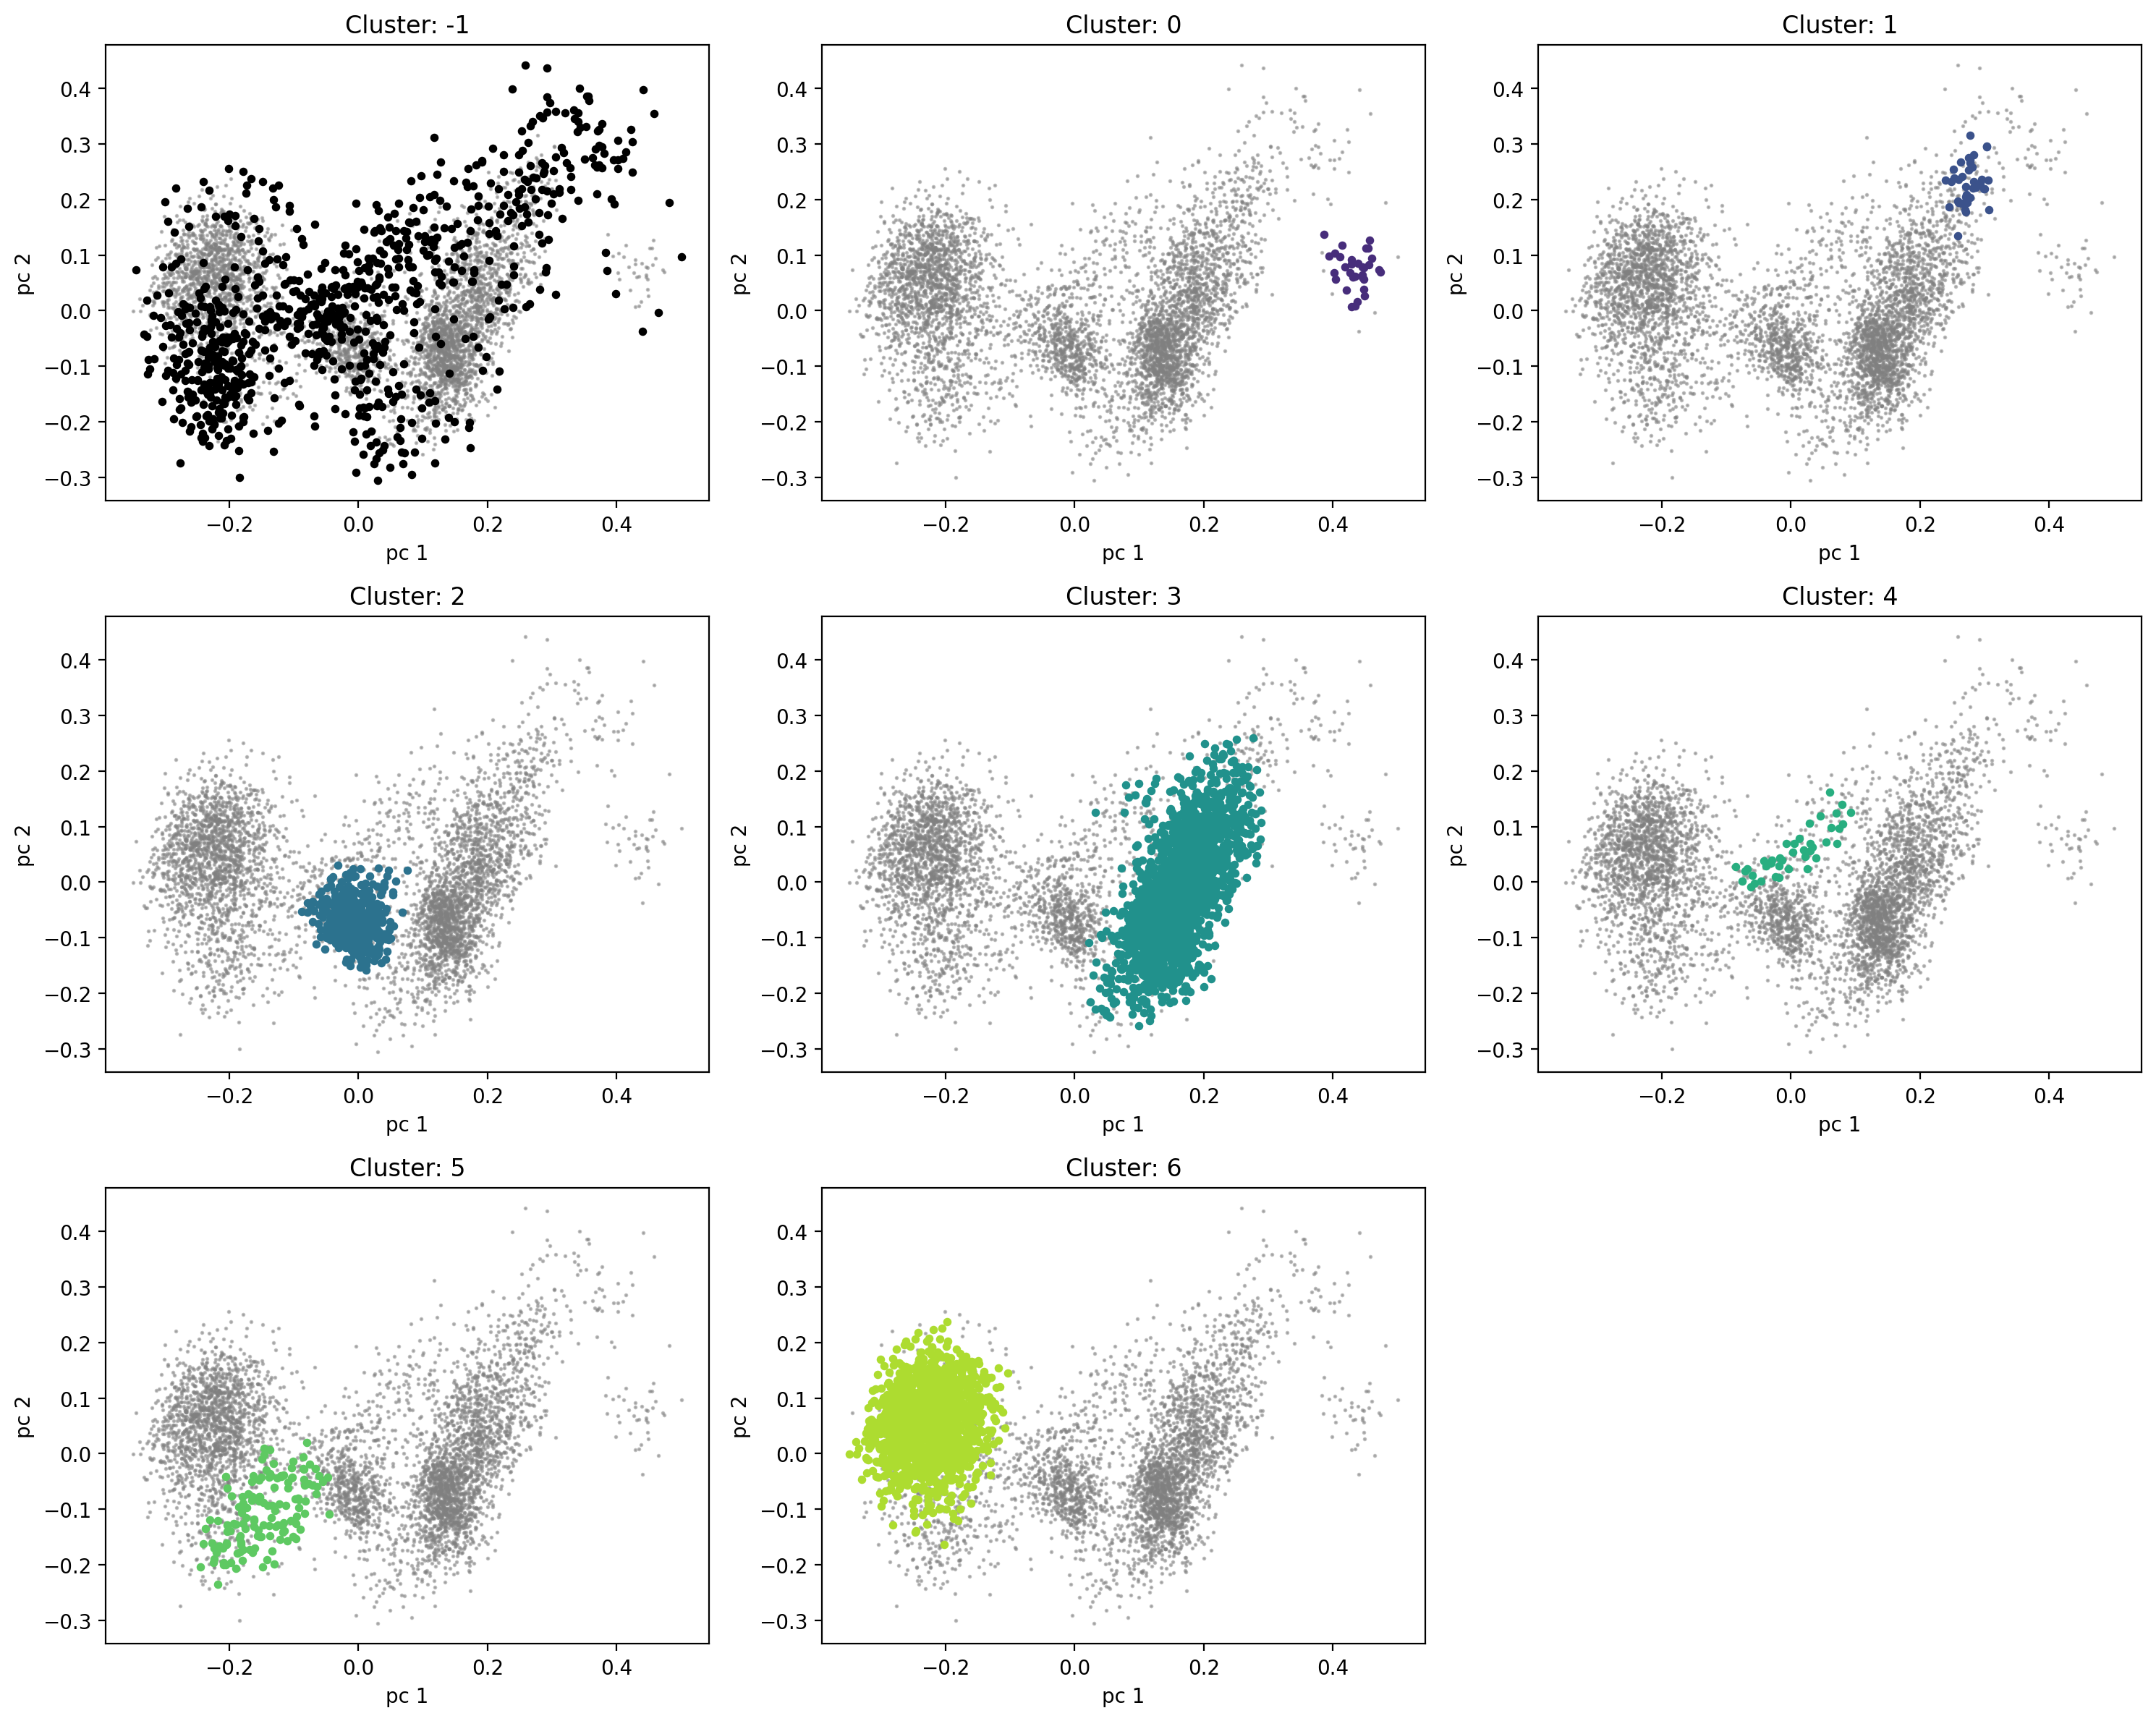

In [22]:
fig, ax = plotTools.get_axes(len(np.unique(clusterer.labels_)),
                             3,res=200)

for i,c in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == c
    ax[i].scatter(X[mask,0], X[mask,1], 
                  color=colors[i], s=10, zorder=2)
    ax[i].set_ylabel('pc 2')
    ax[i].set_xlabel('pc 1')
    ax[i].set_title(f'Cluster: {c}')
    ax[i].scatter(X[:,0], X[:,1], c='0.5', 
                  s=1, zorder=1, alpha=0.5)
fig.tight_layout()
fig.savefig('lpca_hdbscan_vs_ioan_5000pt_cbyc.png')

In [23]:
for v in np.unique(clusterer.labels_):
    if v == -1:
        mask = clusterer.labels_ == v
        print(f"Noise clusters: {len(clusterer.labels_[mask])}")
    if v > -1:
        mask = clusterer.labels_ == v
        print(f"Clust:{v} - counts: {np.bincount(clusterer.labels_[mask])[-1]}")

Noise clusters: 836
Clust:0 - counts: 32
Clust:1 - counts: 39
Clust:2 - counts: 455
Clust:3 - counts: 2070
Clust:4 - counts: 40
Clust:5 - counts: 137
Clust:6 - counts: 1391


In [24]:
np.savetxt('soap_lpca_hdbscan.labels', clusterer.labels_)

## UMAP DATA loading

In [25]:
sysdir_path = './dimred_data/'
sysname = 'umap_n_Z1_Z3_Nframe5000.npy'

In [26]:
X = np.load(sysdir_path+sysname)
X.shape

(5000, 2)

In [27]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(X)

In [28]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [29]:
colors = make_colors(clusterer.labels_, mode='tab20')

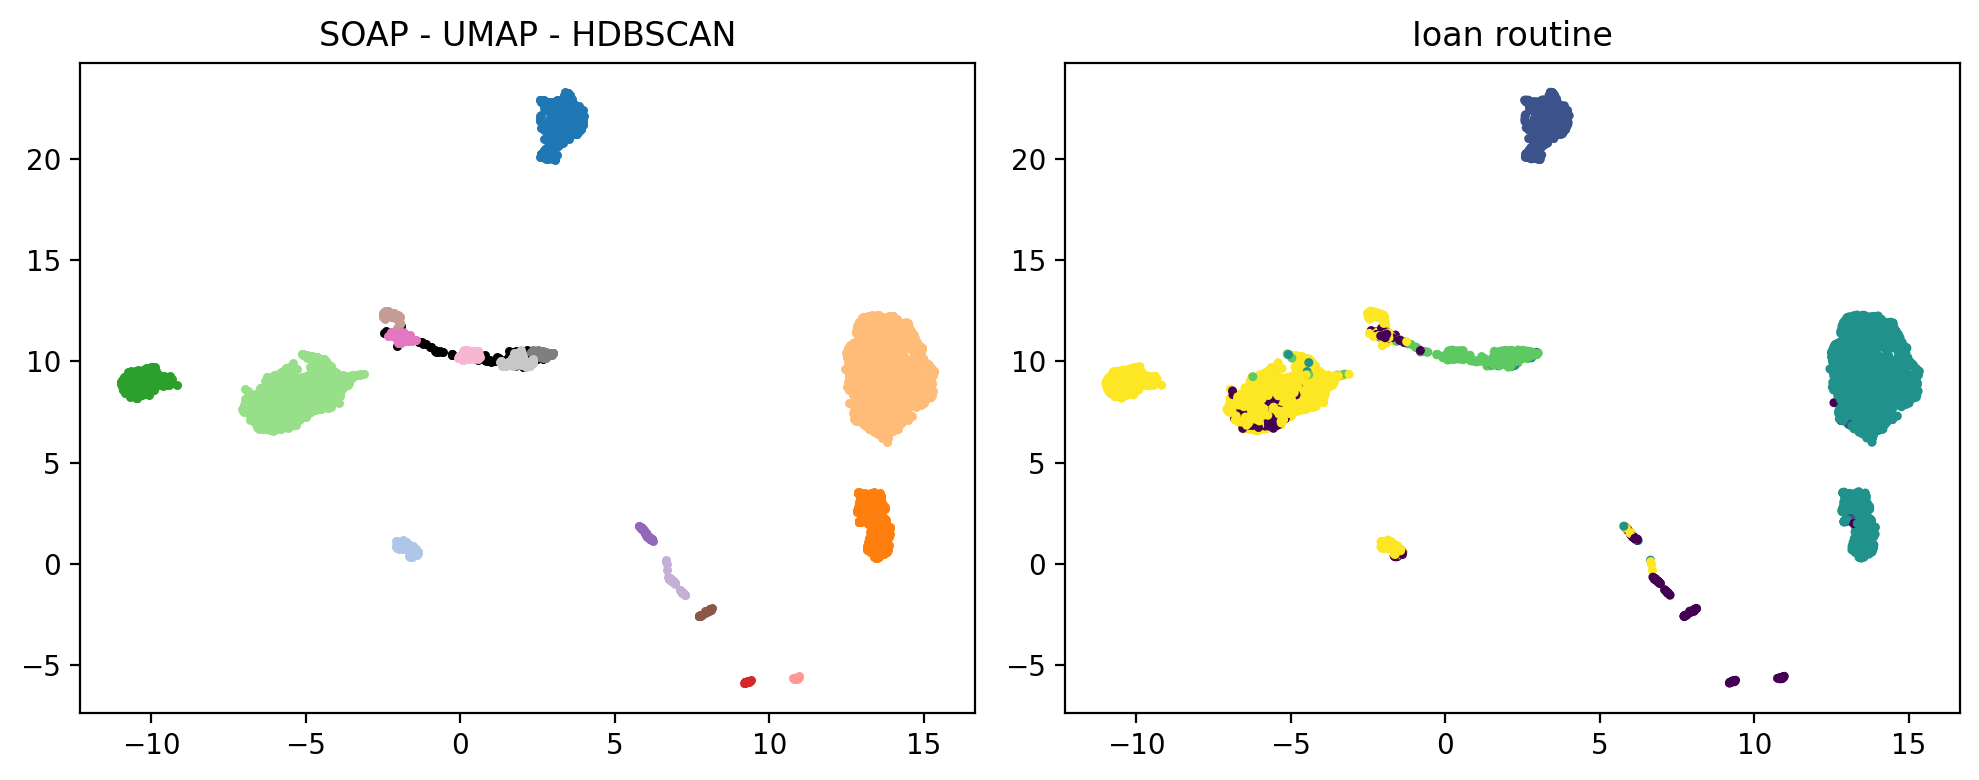

In [31]:
fig, ax = plotTools.get_axes(2,2,res=200)

for i,c in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == c
    ax[0].scatter(X[mask,0], X[mask,1], color=colors[i], s=5)
    ax[0].set_title('SOAP - UMAP - HDBSCAN')
    
ax[1].scatter(X[:,0], X[:,1], c=og_labels, s=5)
ax[1].set_title('Ioan routine')
fig.tight_layout()
fig.savefig('umap_hdbscan_vs_ioan_5000pt.png')

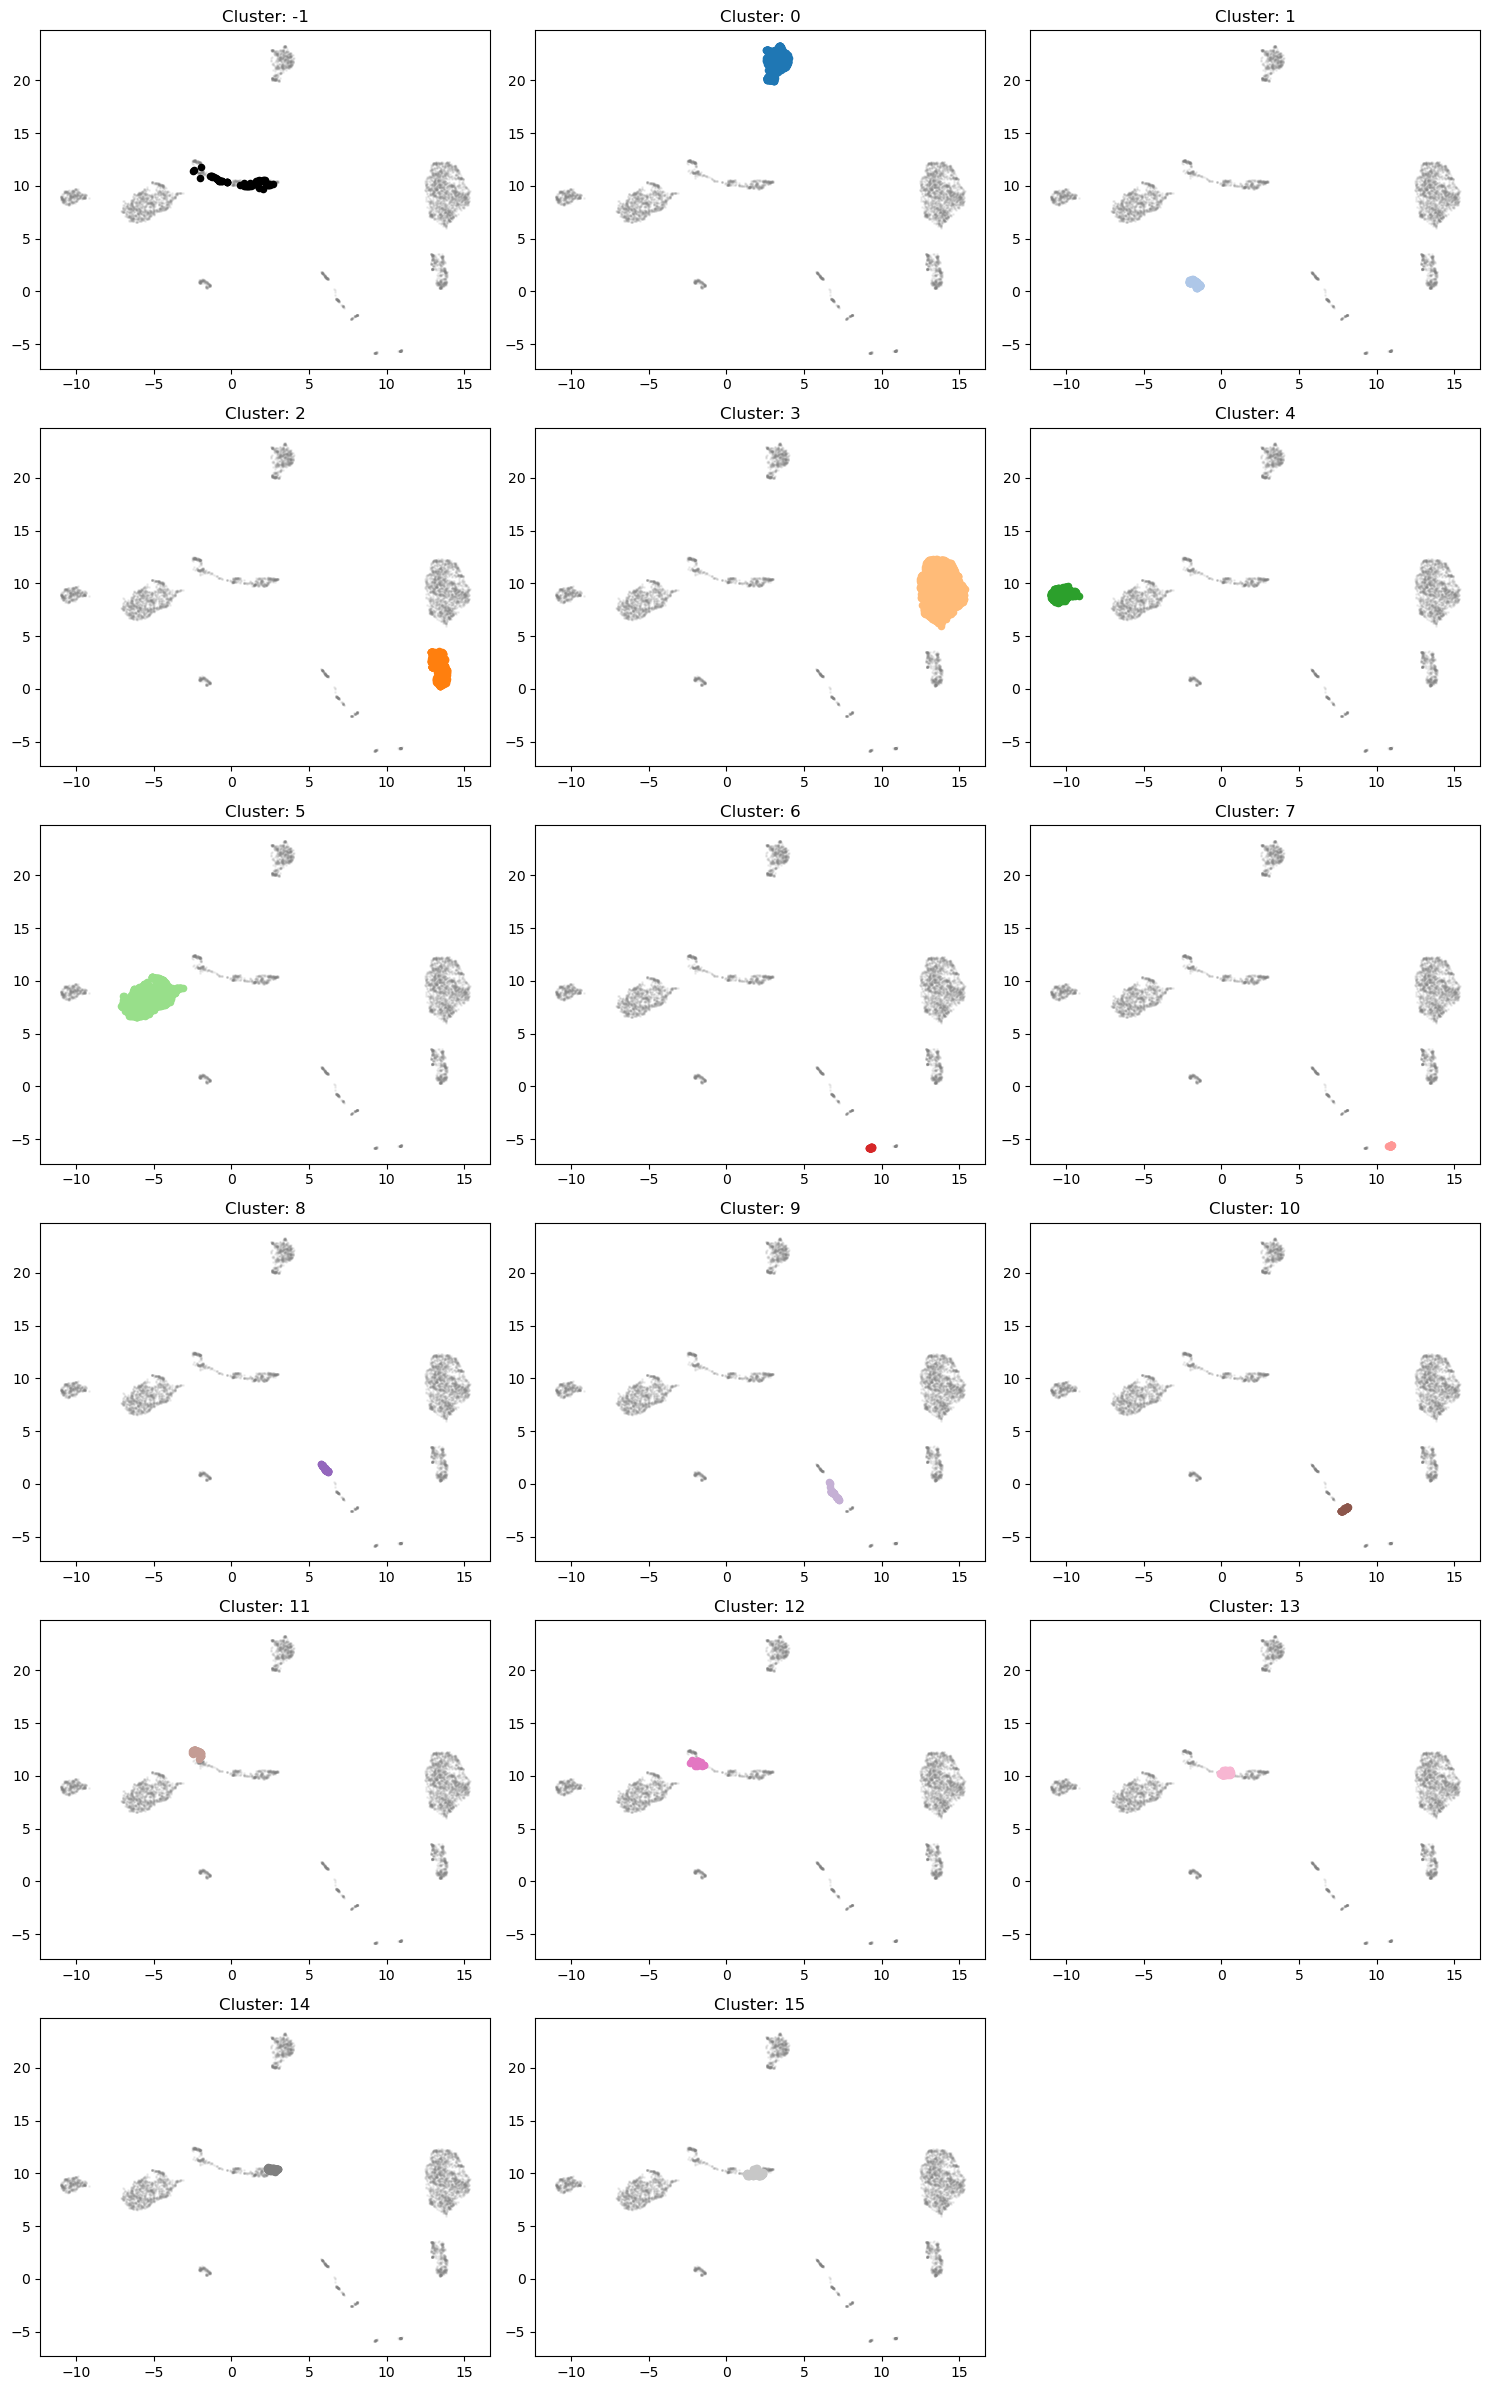

In [33]:
fig, ax = plotTools.get_axes(len(np.unique(clusterer.labels_)),
                             3,res=100)

for i,c in enumerate(np.unique(clusterer.labels_)):
    mask = clusterer.labels_ == c
    ax[i].scatter(X[mask,0], X[mask,1], 
                  color=colors[i], s=20, zorder=2)
    ax[i].set_title(f'Cluster: {c}')
    ax[i].scatter(X[:,0], X[:,1], c='0.5', 
                  s=1, zorder=1, alpha=0.1)
fig.tight_layout()
fig.savefig('umap_hdbscan_vs_ioan_5000pt_cbyc.png')

In [34]:
for v in np.unique(clusterer.labels_):
    if v == -1:
        mask = clusterer.labels_ == v
        print(f"Noise clusters: {len(clusterer.labels_[mask])}")
    if v > -1:
        mask = clusterer.labels_ == v
        print(f"Clust:{v} - counts: {np.bincount(clusterer.labels_[mask])[-1]}")

Noise clusters: 75
Clust:0 - counts: 547
Clust:1 - counts: 119
Clust:2 - counts: 431
Clust:3 - counts: 1755
Clust:4 - counts: 353
Clust:5 - counts: 1050
Clust:6 - counts: 28
Clust:7 - counts: 40
Clust:8 - counts: 79
Clust:9 - counts: 60
Clust:10 - counts: 46
Clust:11 - counts: 88
Clust:12 - counts: 67
Clust:13 - counts: 73
Clust:14 - counts: 80
Clust:15 - counts: 109


In [35]:
np.savetxt('soap_umap_hdbscan.labels', clusterer.labels_)